## Single Task Learning prediction for kinases with data from ChEMBL
This notebook evaluates and compares the performance of three regressors, Random Forests, Neural Networks, and Lasso Regression, all implemented by Scikit-learn for predicting bioactivity values. We are using pIC50 values on a dataset with 110 targets. As we are not interested for optimisation at this point, we run just a quick parameter selection through a 4-fold cross-validation.

## 0. Prerequisites

In [1]:
import numpy as np
import pandas as pd
import keras
import os, pickle

from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import mean_absolute_error as MAE

from sklearn.model_selection import cross_validate, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor

from keras.models import Sequential
from keras.layers import Dense
from keras import regularizers
from keras.wrappers.scikit_learn import KerasRegressor # this is for making a model like every other in scikit
# from sklearn.decomposition import TruncatedSVD as tSVD

import  matplotlib.pyplot as plt
random_seed = 2019
np.random.seed(random_seed)
nfolds=4
njobs =3
pathtosaved = 'ECFP/TrainedModels/'
# RESCALE_FACTOR = 10.0 # 0-10000 -> 0-1000 # no need for that, we use -logIC50 instead.

Using TensorFlow backend.


### Load data file from disk 

In [2]:
Interactions = []

with open("interactions_kinases_IC50_train.tab", 'r') as file:
    header_line = next(file)
    for line in file:
        tokens = line.split()
        # 'Target-ID', 'Compound-ID', 'Std-value'  
        Interactions.append( [tokens[0], tokens[1], -np.log(float(tokens[2])) ])

# we use a dataframe to quickly sort targets wrt #compounds:
DF = pd.DataFrame( Interactions, columns =['Target-ID', 'Compound-ID','Std-value']) 
temp = DF.groupby(['Target-ID']).agg('count').sort_values(by='Compound-ID') # count the number of molecules
Targets = list(temp.index)
Compounds = np.unique(DF['Compound-ID'])
del temp, DF

nT=len(Targets); nC=len(Compounds)

print("There are {0} targets and {1} compounds currently loaded with {2} interactions.".format(nT,nC,len(Interactions)))
print("A DTI matrix would be {0:.4}% dense!".format(100.0*len(Interactions)/nT/nC ))

# first we need to prepare each fp as a feature vector
Fingerprints={} # this contains one list per fingerprint - not efficient...
with open('Compound_Fingerprints.tab', 'r') as f:
    header = f.readline()
    for line in f:
        # each line is Comp-ID, SMILES, FP
        tokens = line.split()
        # we keep only those compounds which have FPs
        if tokens[2] != 'NOFP':
            fp = [int(c) for c in tokens[2] ]
            Fingerprints[ tokens[0] ] = fp
print("%d fingerprints were loaded!" % len(Fingerprints))

There are 110 targets and 23167 compounds currently loaded with 56392 interactions.
A DTI matrix would be 2.213% dense!
23167 fingerprints were loaded!


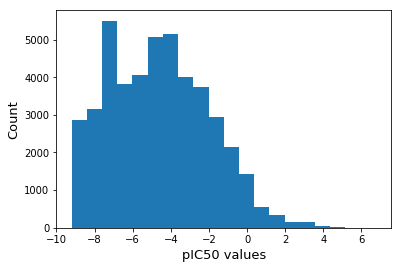

In [25]:
plt.hist([t[2] for t in Interactions_train], bins=20)
plt.xlabel('pIC50 values', fontsize=13)
plt.ylabel('Count',fontsize=13)
# plt.savefig("TrueDistr.png")
plt.show()

### Split to Train-Validation sets

In [3]:
if os.path.isfile("Interactions_Trainset.tab"):
    # train-valid exist so, load them
    print("Loading train/valid sets...")
    Interactions_train = []    
    with open("Interactions_Trainset.tab",'r') as f:
        for line in f:
            tokens = line.split()
            # 'Target-ID', 'Compound-ID', 'pIC50'  
            Interactions_train.append( [tokens[0], tokens[1], float(tokens[2]) ])
    
    Interactions_valid = []        
    with open("Interactions_Validset.tab",'r') as f:
        for line in f:
            tokens = line.split()
            # 'Target-ID', 'Compound-ID', 'pIC50'  
            Interactions_valid.append( [tokens[0], tokens[1], float(tokens[2]) ])
else:
    # train-valid sets do not exist, so create them
    print("Creating new train/valid sets...")
    indices = list(range(len(Interactions)))
    split = int(np.floor( 0.2*( len(indices)) ))
    # split the active interactions in train-test sets
    np.random.shuffle( indices ) # this happens in-place
    
    Interactions_train = [ Interactions[x] for x in indices[split:] ] # the last 80%
    Interactions_valid = [ Interactions[x] for x in indices[:split] ] # the first 20%
    
    with open("Interactions_Trainset.tab",'w') as f:
        for line in Interactions_train:
            f.write( "{0}\t{1}\t{2:.6f}\n".format(line[0],line[1],line[2] ))
            
    with open("Interactions_Validset.tab",'w') as f:
        for line in Interactions_valid:
            f.write( "{0}\t{1}\t{2:.6f}\n".format(line[0],line[1],line[2] ))
print("Basic stats about whole - train - validation sets:")
print( np.mean([x[2] for x in Interactions]), '\t', np.mean([x[2] for x in Interactions_valid]), '\t', np.mean([x[2] for x in Interactions_train]) )
print( np.std([x[2] for x in Interactions]) , '\t', np.std([x[2] for x in Interactions_valid]) , '\t', np.std([x[2] for x in Interactions_train])  )

Loading train/valid sets...
Basic stats about whole - train - validation sets:
-4.604582944988445 	 -4.59704615942543 	 -4.606467008822095
2.5887050752773497 	 2.573166842872859 	 2.592571493135172


## 1. Random Forests

In [4]:
Target_info = {} # this is a "global" variable

RF_all = dict()
Scores_RF_train=[]
count=0
param_grid={'n_estimators':[10,25,50,100,150], 'max_depth':[3,4,5,7,10,15,20], 'max_features':['sqrt','auto']}
for target in Targets:
    Target_info[target] = {}
    # define the train set
    X_train=[]; Y_train=[]
    for point in Interactions_train:
        if point[0]==target:
            X_train.append( Fingerprints[point[1]] )
            Y_train.append( float(point[2]) )
    Target_info[target]['train_size']=len(Y_train) # add info
    if len(Y_train)>40:
        if os.path.isfile(pathtosaved+'RF_'+target+'_'+'pIC50new.sav'):
            # model is already trained - just load
            with open( pathtosaved+'RF_'+target+'_'+'pIC50new.sav', 'rb') as f:
                RFR = pickle.load( f )
        else:
            # we need to ensure there is enough data for CV
            cvr = GridSearchCV(RandomForestRegressor(random_state=2019), param_grid, cv=nfolds, n_jobs=njobs, iid=True)
            # here comes the long step
            cvr.fit(X_train, Y_train)
            # select best parametrisation and train to the complete train-set
            RFR = RandomForestRegressor( n_estimators= cvr.best_params_['n_estimators'],max_features=cvr.best_params_['max_features'], max_depth=cvr.best_params_['max_depth'], random_state=2019)
            RFR.fit(X_train,Y_train)
            # save model
            pickle.dump(RFR, open(pathtosaved+'RF_'+target+'_'+'pIC50new.sav', 'wb'))
        RF_all[target] = RFR
        Scores_RF_train.append( RFR.score( X_train,  Y_train))
        Target_info[target]['RF_train_r2'] = Scores_RF_train[-1] # add info
#         print(Scores_RFR_train[-1])
    else:
        print("Not enough data for %s" % target)
    if count%25==0:
        print("More than %d targets are processed" % count)
        print("Mean score so far: %f" % np.mean(Scores_RF_train))
    count+=1
    
print("Mean score for RF during training = %f" % np.mean(Scores_RF_train) )

More than 0 targets are processed
Mean score so far: 0.898205
More than 25 targets are processed
Mean score so far: 0.882185
More than 50 targets are processed
Mean score so far: 0.881075
More than 75 targets are processed
Mean score so far: 0.889067
More than 100 targets are processed
Mean score so far: 0.886581
Mean score for RF during training = 0.885830


## 2. Neural Networks

In [ ]:
NN_all = dict()
Scores_NN_train=[]
param_grid={'hidden_layer_sizes':[(50),(100,20),(100,50),(500,20,10)] }
count=0
for target in Targets:
    # define the train set
    X_train=[]; Y_train=[]
    for point in Interactions_train:
        if point[0]==target:
            X_train.append( Fingerprints[point[1]] )
            Y_train.append( float(point[2]) )
    if len(Y_train)>40:
        if os.path.isfile(pathtosaved+'NN_'+target+'_'+'pIC50new.sav'):
            # model is already trained - just load
            with open( pathtosaved+'NN_'+target+'_'+'pIC50new.sav', 'rb') as f:
                MLPR = pickle.load( f )
        else:
            # we need to ensure there is enough data for CV
            cvr = GridSearchCV(MLPRegressor(activation='tanh', solver='lbfgs', random_state=2019), param_grid, cv=nfolds, n_jobs=njobs, iid=True)
            cvr.fit(X_train, Y_train)
            # select best parametrisation and train to the complete train-set
            MLPR = MLPRegressor( hidden_layer_sizes = cvr.best_params_['hidden_layer_sizes'], activation='tanh', solver='lbfgs', random_state=2019)
            MLPR.fit(X_train,Y_train)
            pickle.dump(MLPR, open(pathtosaved+'NN_'+target+'_'+'pIC50new.sav', 'wb'))
        NN_all[target] = MLPR
        Scores_NN_train.append( MLPR.score( X_train,  Y_train))
        Target_info[target]['NN_train_r2'] = Scores_NN_train[-1] # add info
#         print(Scores_MLPR_train[-1])
    else:
        print("Not enough data for %s" % target)
    if count%25==0:
        print("More than %d targets are processed" % count)
        print("Mean score so far: %f" % np.mean(Scores_NN_train))
    count+=1
    
print("Mean score for NN during training = %f" % np.mean(Scores_NN_train))

## 3. Lasso Regression

In [ ]:
from sklearn.linear_model import Lasso

LR_all = dict()
Scores_LR_train=[]
param_grid={'alpha':[1, 0.5, 0.1, 0.01]}
count=0
for target in Targets:
    # define the train set
    X_train=[]; Y_train=[]
    for point in Interactions_train:
        if point[0]==target:
            X_train.append( Fingerprints[point[1]] )
            Y_train.append( float(point[2]) )
    
    if os.path.isfile(pathtosaved+'LR_'+target+'_'+'pIC50new.sav'):
        # model is already trained - just load
        with open( pathtosaved+'LR_'+target+'_'+'pIC50new.sav', 'rb') as f:
            LR = pickle.load( f )
    else:
        # cross validation
        cvr = GridSearchCV(Lasso(random_state=2019, max_iter=3000), param_grid, cv=nfolds, n_jobs=njobs, iid=True)
        cvr.fit(X_train, Y_train)
        # select best parametrisation
        LR = Lasso( alpha= cvr.best_params_['alpha'], max_iter=3000, random_state=2019)
        pickle.dump(LR, open(pathtosaved+'LR_'+target+'_'+'pIC50new.sav', 'wb'))
    LR.fit(X_train,Y_train)
    Scores_LR_train.append( LR.score( X_train,  Y_train))
    Target_info[target]['LR_train_r2'] = Scores_LR_train[-1] # add info
    LR_all[target] = LR
#     print(Scores_LR_train[-1])
    if count%25==0:
        print("More than %d targets are processed" % count)
        print("Mean score so far: %f" % np.mean(Scores_LR_train))
    count+=1 

print("Mean score for LR during training = %f" % np.mean(Scores_LR_train) )

## 4. Personalised NN with Keras

In [7]:
myNN_all = dict()
Scores_myNN_train=[]
param_grid={'lamda':[0.2, 0.1, 0.01, 0.001]}
count=0

def mymodel(lamda, init=-4.5):
    model = Sequential()

    model.add(Dense(units=100, activation='relu', kernel_regularizer=regularizers.l2(lamda), input_dim=2048))
    model.add(Dense(units=20,  activation='relu', kernel_regularizer=regularizers.l2(lamda), input_dim=100 ))
    myinit = keras.initializers.Constant(value=init)
    model.add(Dense(1, kernel_initializer=myinit, activity_regularizer=regularizers.l1(0.001)))
    
    model.compile(loss='mean_squared_error', optimizer=keras.optimizers.adam(lr=0.001))
    return model

for target in Targets:
    # define the train set
    X_train=[]; Y_train=[]
    for point in Interactions_train:
        if point[0]==target:
            X_train.append( Fingerprints[point[1]] )
            Y_train.append( float(point[2]) )
        
    if len(Y_train)>40:
        X_train = np.array( X_train )

        myNN = KerasRegressor(build_fn=mymodel, init=-4.5, epochs=250, batch_size=20, verbose=0)
        
        # fit model to data:
        cvr = GridSearchCV(myNN, param_grid=param_grid, cv=nfolds, n_jobs=njobs, iid=True)
        cvr.fit(X_train, Y_train)
        
        myNN = KerasRegressor(build_fn=mymodel, init=-4.5, lamda=cvr.best_params_['lamda'], epochs=250, batch_size=20, verbose=0)
        myNN.fit(X_train,Y_train)
        Y_NN = myNN.predict(X_train)
        # get scores and details:
        Scores_myNN_train.append( r2_score(Y_train, Y_NN) )
        Target_info[target]['my_train_r2'] = Scores_myNN_train[-1] # add info
#         print("R2 score for {0} with {1} items = {2:.3f}".format(target, len(Y_train), Scores_myNN_train[-1]))
        myNN_all[target] = myNN # save model for validation

    else:
        print("Not enough data for %s" % target)
    if count%20==0:
        print("More than %d targets are processed" % count)
        print("Mean score so far: %f" % np.mean(Scores_myNN_train))
    count+=1
    
print("Mean score for myNN during training = %f" % np.mean(Scores_myNN_train) )







More than 0 targets are processed
Mean score so far: 0.987782
More than 20 targets are processed
Mean score so far: 0.976923
More than 40 targets are processed
Mean score so far: 0.977066
More than 60 targets are processed
Mean score so far: 0.976916
More than 80 targets are processed
Mean score so far: 0.976251
More than 100 targets are processed
Mean score so far: 0.974387
Mean score for myNN during training = 0.974303


## 5. Evaluation

In [8]:
Pred_NN = []; Pred_RF  = []; Pred_LR = []; Pred_my=[];
True_vals = []
Pred_pertarget = dict() # contains lists with tuples: (true, pred_RF, pred_NN)

with open("SingleTL_final_results.txt",'w') as f:
    # this file contains all the important stuff for the comparison
    f.write("Target\tCompound\tTrue\tRFR\tMLPR\tLR\tKeras\n")
    for point in Interactions_valid:
        # point = [ target, compound, pIC50 ]
        True_vals.append( float(point[2]) )
        x_test = np.array( Fingerprints[point[1]] ).reshape(1,-1) # prepare for prediction

        model = RF_all[point[0]]
        Pred_RF.append( model.predict( x_test ) )

        model = NN_all[point[0]]
        Pred_NN.append( model.predict( x_test ) )

        model = LR_all[point[0]]
        Pred_LR.append( model.predict( x_test ) )
        
        model = myNN_all[point[0]]
        Pred_my.append( model.predict( x_test ) )

        f.write("{0}\t{1}\t{2}\t{3}\t{4}\t{5}\t{6}\n".format(point[0], point[1], point[2], Pred_RF[-1][0], Pred_NN[-1][0], Pred_LR[-1][0], Pred_my[-1][0]))

        if point[0] in Pred_pertarget:
            Pred_pertarget[point[0]].append( (True_vals[-1], Pred_RF[-1][0], Pred_NN[-1][0], Pred_LR[-1][0], Pred_my[-1][0])  )
        else:
            # first time for this protein
            Pred_pertarget[point[0]] = [ (True_vals[-1], Pred_RF[-1][0], Pred_NN[-1][0], Pred_LR[-1][0], Pred_my[-1][0]) ]
        
print("Performance for RF = %f" % r2_score( True_vals, Pred_RF ))
print("Performance for NN = %f" % r2_score( True_vals, Pred_NN ))
print("Performance for LR = %f" % r2_score( True_vals, Pred_LR ))
print("Performance for Keras = %f" % r2_score( True_vals, Pred_my ))

Performance for RF = 0.648743
Performance for NN = 0.582632
Performance for LR = 0.591053
Performance for Keras = 0.625272


In [22]:
Scores_RF_valid_pertarget = []
Scores_NN_valid_pertarget = []
Scores_LR_valid_pertarget = []
Scores_my_valid_pertarget = []

for target in Pred_pertarget:
    true=[]
    pred_RF=[]; pred_NN=[]; pred_LR=[]; pred_my =[] # temp variables
    # aggregate predictions
    for point in Pred_pertarget[target]:
        true.append( point[0] )
        pred_RF.append( point[1] )
        pred_NN.append( point[2] )
        pred_LR.append( point[3] )
        pred_my.append( point[4] )
    Target_info[target]['test_size']=len(true) # add info
    
    # calculate performance for each method
    r2 = r2_score(true, pred_RF)
    Target_info[target]['RF_valid_r2'] = r2 # add info
    Scores_RF_valid_pertarget.append( r2 )
    
    r2 = r2_score(true, pred_NN)
    Target_info[target]['NN_valid_r2'] = r2 # add info
    Scores_NN_valid_pertarget.append( r2 )

    r2 = r2_score(true, pred_LR)
    Target_info[target]['LR_valid_r2'] = r2 # add info
    Scores_LR_valid_pertarget.append( r2 )
    
    r2 = r2_score(true, pred_my)
    Target_info[target]['my_valid_r2'] = r2 # add info
    Scores_my_valid_pertarget.append( r2 )

    print("R2 score for {0}, RF | NN | LR | Keras = {1:.2f} | {2:.2f} | {3:.2f} | {4:.3f}".format(target, Scores_RF_valid_pertarget[-1], Scores_NN_valid_pertarget[-1], Scores_LR_valid_pertarget[-1], Scores_my_valid_pertarget[-1]))

In [23]:
print("Mean per target R2-score for RF = {0:.4f} and std = {1:.4f}".format( np.mean(Scores_RF_valid_pertarget), np.std(Scores_RF_valid_pertarget) )) 
print("Mean per target R2-score for NN = {0:.4f} and std = {1:.4f}".format( np.mean(Scores_NN_valid_pertarget), np.std(Scores_NN_valid_pertarget) ))
print("Mean per target R2-score for LR = {0:.4f} and std = {1:.4f}".format( np.mean(Scores_LR_valid_pertarget), np.std(Scores_LR_valid_pertarget) ))
print("Mean per target R2-score for my = {0:.4f} and std = {1:.4f}".format( np.mean(Scores_my_valid_pertarget), np.std(Scores_my_valid_pertarget) ))

Mean per target R2-score for RF = 0.4983 and std = 0.1681
Mean per target R2-score for NN = 0.3896 and std = 0.2398
Mean per target R2-score for LR = 0.4190 and std = 0.2135


## 6. Analysis and Plotting

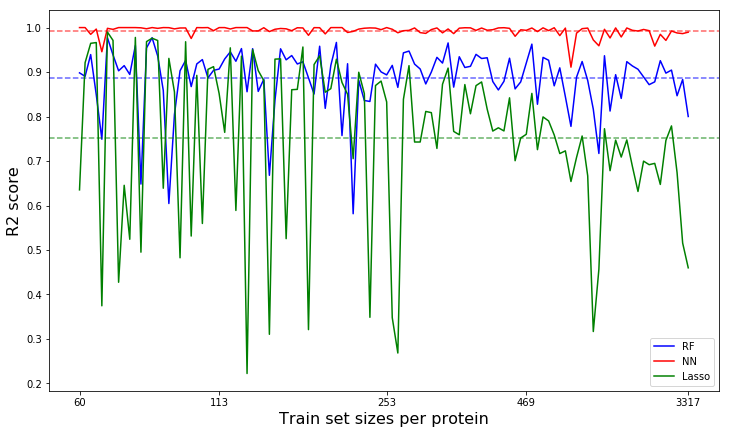

In [24]:
plt.figure(figsize=(12,7))

Y = [Target_info[x]['RF_train_r2'] for x in Targets]
plt.plot(Y,'b', label='RF')
plt.axhline(np.mean(Y),color='b', linestyle='--', alpha=0.6)

Y = [Target_info[x]['NN_train_r2'] for x in Targets]
plt.plot(Y,'r', label='NN')
plt.axhline(np.mean(Y),color='r', linestyle='--', alpha=0.6)

Y = [Target_info[x]['LR_train_r2'] for x in Targets]
plt.plot(Y,'g', label='Lasso')
plt.axhline(np.mean(Y),color='g', linestyle='--', alpha=0.6)

Y = [Target_info[x]['my_train_r2'] for x in Targets]
plt.plot(Y,'m', label='Keras')
plt.axhline(np.mean(Y),color='m', linestyle='--', alpha=0.6)

Sizes = [Target_info[x]['train_size'] for x in Targets]
xi = [0,25,55,80,109]
plt.xticks(xi, [Sizes[t] for t in xi])
plt.xlabel('Train set sizes per protein',fontsize=16)
plt.ylabel('R2 score',fontsize=16)
# plt.xticks( x, rotation='vertical')
plt.legend(loc=4)
# plt.title("Training Performance")
plt.savefig("Train-all.png")
plt.show()

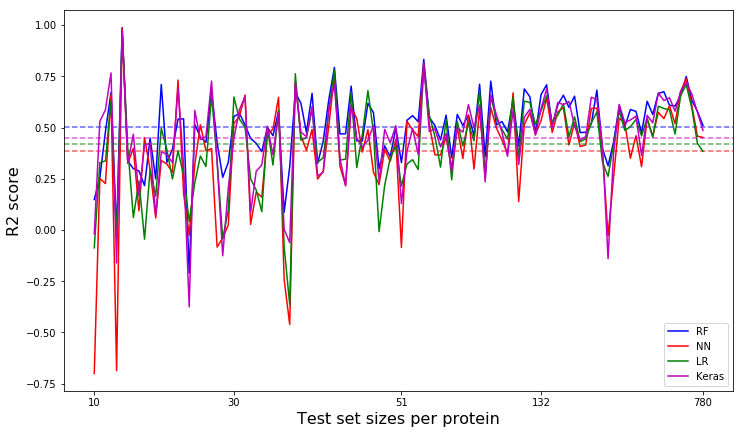

In [13]:
plt.figure(figsize=(12,7))

Y = [Target_info[x]['RF_valid_r2'] for x in Targets]
plt.plot(Y,'b', label='RF')
plt.axhline(np.mean(Y),color='b', linestyle='--', alpha=0.6)

Y = [Target_info[x]['NN_valid_r2'] for x in Targets]
plt.plot(Y,'r', label='NN')
plt.axhline(np.mean(Y),color='r', linestyle='--', alpha=0.6)

Y = [Target_info[x]['LR_valid_r2'] for x in Targets]
plt.plot(Y,'g', label='LR')
plt.axhline(np.mean(Y),color='g', linestyle='--', alpha=0.6)

Y = [Target_info[x]['my_valid_r2'] for x in Targets]
plt.plot(Y,'m', label='Keras')
plt.axhline(np.mean(Y),color='m', linestyle='--', alpha=0.6)
plt.legend(loc=4)

Sizes = [Target_info[x]['valid_size'] for x in Targets]
xi = [0,25,55,80,109]
plt.xticks(xi, [Sizes[t] for t in xi])
plt.xlabel('Valid. set sizes per protein',fontsize=16)
plt.ylabel('R2 score',fontsize=16)
# plt.title("Validation Performance")
plt.savefig("Valid-all.png")
plt.show()

### Just a scatterplot for all three approaches

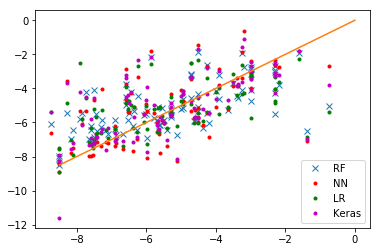

In [25]:
target = Targets[70]
true=[]
pred_RF=[]; pred_NN=[]; pred_LR=[]; pred_my=[];
# aggregate predictions
for tuples in Pred_pertarget[target]:
    true.append( tuples[0] )
    pred_RF.append( tuples[1] )
    pred_NN.append( tuples[2] )
    pred_LR.append( tuples[3] )
    pred_my.append( tuples[4] )
    
plt.figure()
plt.plot(true, pred_RF,'x',label='RF')
plt.plot(true, pred_NN,'r.',label='NN')
plt.plot(true, pred_LR,'g.',label='LR')
plt.plot(true, pred_my,'m.',label='Keras')
plt.plot([-8.5,0],[-8.5,0])

plt.legend(loc=4)
plt.show()

### How to get the dominant parametrisations

In [17]:
from scipy.stats import mode
temp1 = []; temp2=[]; temp3=[]; temp4=[]; temp5=[];
for model in LR_all:
    temp1.append( LR_all[model].get_params()['alpha'] )
    temp2.append( RF_all[model].get_params()['n_estimators'] )
    temp3.append( RF_all[model].get_params()['max_depth'] )
    temp4.append( NN_all[model].get_params()['hidden_layer_sizes'])
    temp5.append( myNN_all[model].get_params()['lamda'] )
print('LR - best alpha = {0} with {1}.'.format( mode(temp1)[0], mode(temp1)[1][0]) )
print('RF - best n-estimat = {0} with {1}.'.format( mode(temp2)[0], mode(temp2)[1][0]) )
print('RF - best max-depth = {0} with {1}.'.format( mode(temp3)[0], mode(temp3)[1][0]) )
print('Keras - best lamda = {0} with {1}'.format( mode(temp5)[0], mode(temp5)[1][0]) )
temp_dict={}
for x in temp4:
    if str(x) in temp_dict:
        temp_dict[ str(x) ]+=1
    else:
        temp_dict[ str(x) ] = 1
print("NN - hidden layers:")
print( temp_dict)
# for model in NN_all:
#     print( NN_all[model].get_params()['hidden_layer_sizes'])

LR - best alpha = [0.01] with 91.
RF - best n-estimat = [150] with 47.
RF - best max-depth = [20] with 73.
Keras - best lamda = [0.2] with 42
NN - hidden layers:
{'50': 23, '(50, 20, 10)': 36, '(50, 100)': 19, '(50, 20)': 32}


### Cool info about coefficients by Lasso

[489, 1199, 666, 1750, 1858, 1416, 1160, 202, 311, 1453, 1019, 167, 1114, 745, 352, 491, 1607, 1171, 1152, 1747]


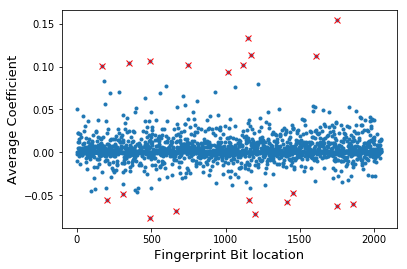

In [18]:
# try to trace-back the bits of high-impact
Coef = np.zeros(2048)
for model in LR_all:
#     cf = model.coef_xi = [0,25,55,80,109]

    Coef += LR_all[model].coef_

Coef = Coef/110  

indices = []
ind = np.argsort(Coef)
[indices.append(x) for x in ind[:10] ]
[indices.append(x) for x in ind[-10:] ]
print(indices)

plt.plot( range(2048), Coef, '.')
plt.plot( indices, Coef[indices], 'rx')
# plt.plot( Coef[indices], 'o')
plt.xlabel("Fingerprint Bit location",fontsize=13)
plt.ylabel("Average Coefficient",fontsize=13)
# plt.title("Most important FP bits")
plt.savefig("Lasso-bits.png")
plt.show()

In [19]:
print("RMSE for RF = %f" % np.sqrt( MSE(True_vals, Pred_NN) ))
print("RMSE for NN = %f" % np.sqrt( MSE(True_vals, Pred_LR) ))
print("RMSE for LR = %f" % np.sqrt( MSE(True_vals, Pred_RF) ))
print("RMSE for Keras = %f" % np.sqrt( MSE(True_vals, Pred_my) ))

RMSE for RF = 1.662369
RMSE for NN = 1.645514
RMSE for LR = 1.525038
RMSE for Keras = 1.575165


### Some comparisons of distributions

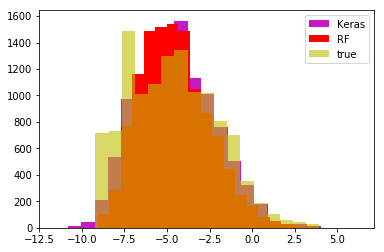

In [58]:
# plt.figure()
plt.hist([t[0] for t in Pred_my],bins=20,color='m',alpha=0.9, label="Keras")

plt.hist([t[0] for t in Pred_RF],bins=20,color='r',label="RF")

plt.hist([t for t in True_vals],bins=20,color='y',alpha=0.6, label='true')
plt.legend(loc=1)
plt.show()

## 7. Save models

In [28]:
import pickle
wheretosave='ECFP/TrainedModels/'
# !(mkdir TrainedModels ) 

for target in Targets:
#     model = RF_all[target]
#     filename = wheretosave+'RF_'+target+'_'+'pIC50model.sav'
#     pickle.dump(model, open(filename, 'wb'))
    
    model = LR_all[target]
    filename = wheretosave+'LR_'+target+'_'+'pIC50new.sav'
    pickle.dump(model, open(filename, 'wb'))
    
    model = NN_all[target]
    filename = wheretosave+'NN_'+target+'_'+'pIC50new.sav'
    pickle.dump(model, open(filename, 'wb'))
    
    model = myNN_all[target]
    model_json = model.to_json()
    with open(wheretosave+'myNN_'+target+'_'+"pIC50new.json",'w') as json_f:
        json_f.write(model_json)
    MTLR.save_weights(wheretosave+'myNN_'+target+'_'+'pIC50new.h5')
    

### LOAD:

In [ ]:
# wheretosave='ECFP/TrainedModels/'

# for target in Targets:
#     with open( wheretosave+'RF_'+target+'_'+'pIC50model.sav', 'rb') as f:
#         RF_all[target] = pickle.load( f )
    
#     with open( wheretosave+'LR_'+target+'_'+'pIC50new.sav', 'rb') as f:
#         LR_all[target] = pickle.load( f )
    
#     with open( wheretosave+'NN_'+target+'_'+'pIC50new.sav', 'rb') as f:
#         NN_all[target] = pickle.load( f )

## Appendix - Old pieces of code

print("Stds per method for training:")
print(np.std(Scores_RF_train))
print(np.std(Scores_NN_train))
print(np.std(Scores_LR_train))

print("Stds per method for testing :")
print(np.std(Scores_RF_valid_pertarget))
print(np.std(Scores_NN_valid_pertarget))
print(np.std(Scores_LR_valid_pertarget))

Scores_LR_valid = []
Scores_RFR_valid = []
Scores_MLPR_valid= []
for i in range(len(Interactions_valid)):
    Scores_LR_valid.append( np.abs( float(Interactions_valid[i][2]) - Pred_LR[i][0])/float(Interactions_valid[i][2]) )
    Scores_RFR_valid.append( np.abs( float(Interactions_valid[i][2]) - Pred_RFR[i][0])/float(Interactions_valid[i][2]) )
    Scores_MLPR_valid.append( np.abs( float(Interactions_valid[i][2]) - Pred_MLPR[i][0])/float(Interactions_valid[i][2]) )

plt.figure(figsize=(15,5))
plt.plot(Scores_LR_valid,'g', label='LR')
plt.plot(Scores_RFR_valid,'b', label='RF')
plt.plot(Scores_MLPR_valid,'r', label='NN')
plt.legend(loc=1)
plt.xlabel('Protein sets')
plt.ylabel('Residuals')
plt.title("MAE on validation set")
plt.show()

for i in range(50):
    print(True_vals[i],'\t', Pred_LR[i])
print(     MSE( True_vals, Pred_LR ))
print(r2_score( True_vals, Pred_LR ))
print(     MAE( True_vals, Pred_LR ))